# 2조 - 정기 예금 가입 여부 예측 모델링

## 0. 초기화

### 0.1 패키지 로드

In [59]:
import os
import random
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

### 0.2 공통 파라메터 설정

In [60]:
# Seed 고정
SEED = 42 # SEED값만 바꿔도 다른 결과가 나올 수 있다. 결과제출시 이 값만 계속 바꿔도 결과값이 달라질수 있다.

# Variance threshold 설정
VAR_THRESHOLD = 0.01

# FDR alpha 설정
FDR_ALPHA = 0.05

# RFECV cross-validation folds 설정
RFE_CV = 4

# H2O 파라미터 설정
MAX_MODELS = 10
MAX_RUNTIME_SECS = 600
MAX_RUNTIME_SECS_PER_MODEL = 200

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('_mpl-gallery') # matplotlib의 시각화 스타일 지정
sns.set_palette('Set2', n_colors=10)
plt.rc('font', family='AppleGothic') #윈도우에서는 malgun gothic
plt.rc('axes', unicode_minus=False)

font = {'fontsize':18, 'fontstyle':'italic', 'backgroundcolor':'white', 'color':'black', 'fontweight': 'bold'} # for plot title

# 표시할 최대 행 수를 None으로 설정하여 모든 행을 출력
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### 0.3 seed 고정
* 참고 
    * 머신러닝 코드 작성시 seed를 고정하는 이유는 코드 실행결과의 재현성을 확보하기 위함
    * 난수 생성기는 머신러닝의 다양한 과정에서 사용, 이때 seed를 설정하면 같은 난수를 생성하여 코드 실행시 동일한 결과 생성


### 0.4 공통함수

* DataFrame 출력시 모든 행과 열이 보이도록 출력

In [61]:
def print_all(df):
    with pd.option_context('display.max_rows',None):
        with pd.option_context('display.max_columns',None):
            with pd.option_context('display.float_format', '{:,.4f}'.format):
                display(df)

## 1. 데이터 불러오기

In [62]:
# train 데이터 불러오기
train_data = pd.read_csv('./data/train.csv', sep=',')
# test 데이터 불러오기
test_data = pd.read_csv('./data/test.csv', sep=',')

## <b>Column Definition and Key value</b>
| 변수명	| 데이터타입	| 설명	| 범주 값 | 
|---------|-----------|-----|----------------------------------------------|
| age	  | 수치형	   | 나이	| 해당 없음 |
| job	  | 범주형	   | 직업	|admin, unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, service |
| marital |	범주형	   | 결혼상태 | married, divorced, single (사별해도 divorced로 포함) |
| education	 | 범주형	| 학력	 | unknown, secondary, primary, tertiary |
| default	 | 범주형	| 신용  채무 불이행 상태 | 	yes, no |
| balance	| 수치형	| 연평균 잔액(단위: 유로)	| 해당 없음 |
| housing	| 범주형	| 주택대출 여부	| yes, no |
| loan	 | 범주형	| 개인대출 여부	 | yes, no | 
| contact	| 범주형	| 최근 연락을 한 방법	| unknown, telephone, cellular |
| day	| 수치형	| 최근 연락을 한 날	| 해당 없음 |
| month	 | 수치형	| 최근 연락을 한 달	 | jan, feb, mar, …, dec |
| duration	| 수치형	| 최근 연락 시 통화 시간	| 해당 없음 | 
| campaign	| 수치형	| 이번 캠페인 관련 취한 연락 횟수 | 	해당 없음 |
| pdays	 | 수치형	| 지난 캠페인 관련하여 마지막 연락으로부터 경과한 일 수 | 	(-1)은 연락 한 적 없음 |
| previous	| 수치형 |	이번 캠페인 이전에 해당 고객에게 취한 연락 횟수	| 해당 없음 |
| poutcome	| 범주형 | 이전 캠페인 참여 여부	| unknown, other, failure, success |
| label	 | 범주형	| 가입 여부(Y) | 	가입(1), 미가입(0) | 


In [63]:
print_all(train_data.head())
print_all(test_data.head())

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,train00001,34,blue-collar,married,primary,no,358,yes,no,unknown,23,may,100,4,-1,0,unknown,0
1,train00002,33,blue-collar,married,secondary,no,-53,yes,no,unknown,20,may,172,1,-1,0,unknown,0
2,train00003,32,management,single,tertiary,no,207,yes,no,cellular,2,feb,56,1,-1,0,unknown,0
3,train00004,37,blue-collar,divorced,secondary,no,638,yes,no,cellular,8,may,326,1,326,2,success,0
4,train00005,33,housemaid,married,secondary,no,826,yes,no,cellular,11,may,256,1,-1,0,unknown,0


,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,test00001,54,management,divorced,tertiary,no,6410,no,no,cellular,20,nov,101,2,-1,0,unknown,NaN
1,test00002,56,unemployed,divorced,primary,no,282,no,no,cellular,28,jan,156,2,-1,0,unknown,NaN
2,test00003,34,management,married,secondary,no,355,no,no,cellular,21,aug,314,3,-1,0,unknown,NaN
3,test00004,55,management,married,tertiary,no,568,no,no,cellular,12,aug,940,10,-1,0,unknown,NaN
4,test00005,38,technician,married,secondary,no,6728,no,no,cellular,21,aug,252,4,-1,0,unknown,NaN


### 1.1 미사용 컬럼 제거
* train, test 데이터 ID 컬럼 제거

In [64]:
drop_columns = ['ID', 'previous']

In [65]:
train_df = train_data.drop(columns=drop_columns).copy()
test_df = test_data.drop(columns=drop_columns).copy()

### 1.2. X, Y 분리

In [66]:
train_y_df = train_df['label'].copy()
train_x_df = train_df.drop(columns=['label']).copy()

#test_y_df = test_df['label'].copy()
test_x_df = test_df.drop(columns=['label']).copy()

print('train shape : ', train_x_df.shape, train_y_df.shape)
print('test shape : ', test_x_df.shape)

train shape :  (31647, 15) (31647,)
test shape :  (13564, 15)


In [67]:
train_x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31647 non-null  int64 
 1   job        31647 non-null  object
 2   marital    31647 non-null  object
 3   education  31647 non-null  object
 4   default    31647 non-null  object
 5   balance    31647 non-null  int64 
 6   housing    31647 non-null  object
 7   loan       31647 non-null  object
 8   contact    31647 non-null  object
 9   day        31647 non-null  int64 
 10  month      31647 non-null  object
 11  duration   31647 non-null  int64 
 12  campaign   31647 non-null  int64 
 13  pdays      31647 non-null  int64 
 14  poutcome   31647 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.6+ MB


* 널값이 없다.

In [68]:
train_y_df.info()

<class 'pandas.core.series.Series'>
RangeIndex: 31647 entries, 0 to 31646
Series name: label
Non-Null Count  Dtype
--------------  -----
31647 non-null  int64
dtypes: int64(1)
memory usage: 247.4 KB


In [69]:
train_y_df.value_counts()

label
0    27945
1     3702
Name: count, dtype: int64

* 클래스 불균형 데이터임을 확인

## 2. 데이터 확인

### 2.1 YData Profiling
- https://ydata-profiling.ydata.ai/docs/master/index.html
- (구) Pandas Profiling

장점
- 데이터에 대한 여러 다양한 통계 정보 및 차트를 보여줌
  - 기술 통계, 상관분석 등
- text 데이터에 대해선 word cloud 자동 생성
- automatic data quality checking/control
- 다른 dataframe끼리 비교 분석

단점
- 무겁고, 오래 걸림
- 데이터 크기가 크면 사용이 어려울 수 있음

In [70]:
# from ydata_profiling import ProfileReport

# print data profiliong report
#data_profile = ProfileReport(train_df, minimal=True, title='Profile Report')
#data_profile.to_widgets()
#data_profile.to_file("output.html")
#data_profile.to_notebook_iframe()

* 수치형 변수들의 요약정보 확인하기

In [71]:
# 수치형 변수만 선택
numeric_data = train_x_df.select_dtypes(include=['number'])

# 수치형 변수 요약정보 확인
numeric_summary = numeric_data.describe()
numeric_summary

,age,balance,day,duration,campaign,pdays
count,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000
mean,40.916833,1370.050084,15.818277,258.088824,2.752615,40.023604
std,10.621773,3122.054996,8.315467,255.737568,3.080952,100.154518
min,18.000000,-4057.000000,1.000000,0.000000,1.000000,-1.000000
25%,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000
50%,39.000000,451.000000,16.000000,180.000000,2.000000,-1.000000
75%,48.000000,1418.500000,21.000000,320.000000,3.000000,-1.000000
max,95.000000,102127.000000,31.000000,3881.000000,63.000000,854.000000


* 문자형 변수들의 요약정보 확인하기

In [72]:
# 문자형 변수만 선택
categorical_data = train_x_df.select_dtypes(exclude=['number'])

# 문자형 변수 요약정보 확인
categorical_summary = categorical_data.describe()
categorical_summary

,job,marital,education,default,housing,loan,contact,month,poutcome
count,31647,31647,31647,31647,31647,31647,31647,31647,31647
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,6773,19042,16250,31089,17617,26617,20525,9647,25918


In [73]:
for col in train_x_df.select_dtypes(exclude=['number']).columns:
    print(f"Value counts for column '{col}' (including NaN):")
    print(train_df[col].value_counts(dropna=False))
    print("-" * 30)

Value counts for column 'job' (including NaN):
job
blue-collar      6773
management       6655
technician       5288
admin.           3657
services         2874
retired          1588
self-employed    1127
entrepreneur     1062
unemployed        917
housemaid         853
student           655
unknown           198
Name: count, dtype: int64
------------------------------
Value counts for column 'marital' (including NaN):
marital
married     19042
single       8993
divorced     3612
Name: count, dtype: int64
------------------------------
Value counts for column 'education' (including NaN):
education
secondary    16250
tertiary      9354
primary       4768
unknown       1275
Name: count, dtype: int64
------------------------------
Value counts for column 'default' (including NaN):
default
no     31089
yes      558
Name: count, dtype: int64
------------------------------
Value counts for column 'housing' (including NaN):
housing
yes    17617
no     14030
Name: count, dtype: int64
---------

## 3. 데이터 전처리

### 3.1 데이터 Cleansing

#### 3.1.1 결측치 처리
- 전체 또는 동일군의 평균, 중앙값, 또는 최빈값으로 채우기
- RandomForest 등 ML 모델로 예측한 값으로 채우기
- 결측치가 많은(null >80%) row 또는 column은 제거

* 컬럼별 널값 비율 확인하기
    * 널값이 없으면 결측치 처리 pass

### 3.2 추가변수 및 파생변수 생성

* 변수들을 통해 의미있는 추가변수 발굴
    * 예측 성능을 높일 수 있다.

#### 3.2.1 이전 켐페인 참여여부 변수 값 재정의

In [74]:
#train_x_df.loc[train_x_df['poutcome']!='success', 'poutcome'] = 'NotSuccess'
#test_x_df.loc[test_x_df['poutcome']!='success', 'poutcome'] = 'NotSuccess'

In [75]:
#train_x_df['poutcome'].value_counts()

#### 3.2.2 loan_status 변수 생성

* housing(주택대출 여부)과 loan(개인대출 여부) 두 대출의 상태를 조합하여 새로운 범주형 변수를 생성.
* 대출 상태 변수는 즉 대출 위험도를 의미한다. 
* 분류
    * no_loans: 두 대출 모두 없음 (housing=no & loan=no)
    * housing_only: 주택 대출만 있음 (housing=yes & loan=no)
    * loan_only: 개인 대출만 있음 (housing=no & loan=yes)
    * both_loans: 두 대출 모두 있음 (housing=yes & loan=yes)

In [76]:
# 훈련데이터 처리
'''
train_x_df['loan_status'] = (
    train_x_df['housing'].map({'yes': 1, 'no': 0}) + train_x_df['loan'].map({'yes': 2, 'no': 0})
)
train_x_df['loan_status'] = train_x_df['loan_status'].map({
    0: 'no_loans',
    1: 'housing_only',
    2: 'loan_only',
    3: 'both_loans'
})

# 테스트데이터 처리
test_x_df['loan_status'] = (
    test_x_df['housing'].map({'yes': 1, 'no': 0}) + test_x_df['loan'].map({'yes': 2, 'no': 0})
)
test_x_df['loan_status'] = test_x_df['loan_status'].map({
    0: 'no_loans',
    1: 'housing_only',
    2: 'loan_only',
    3: 'both_loans'
})
'''

"\ntrain_x_df['loan_status'] = (\n    train_x_df['housing'].map({'yes': 1, 'no': 0}) + train_x_df['loan'].map({'yes': 2, 'no': 0})\n)\ntrain_x_df['loan_status'] = train_x_df['loan_status'].map({\n    0: 'no_loans',\n    1: 'housing_only',\n    2: 'loan_only',\n    3: 'both_loans'\n})\n\n# 테스트데이터 처리\ntest_x_df['loan_status'] = (\n    test_x_df['housing'].map({'yes': 1, 'no': 0}) + test_x_df['loan'].map({'yes': 2, 'no': 0})\n)\ntest_x_df['loan_status'] = test_x_df['loan_status'].map({\n    0: 'no_loans',\n    1: 'housing_only',\n    2: 'loan_only',\n    3: 'both_loans'\n})\n"

* 대출상태 변수를 생성했으므로 기존 housing과 loan변수는 삭제한다.

In [77]:
#train_x_df = train_x_df.drop(columns=['housing', 'loan'])
#test_x_df = test_x_df.drop(columns=['housing', 'loan'])

#### 3.2.4 balance_group 변수 생성

* 연평균 잔액유무 따른 그룹 변수 생성

In [78]:
'''
train_x_df['balance_group'] = 1
train_x_df.loc[train_x_df['balance']<0, 'balance_group'] = 0
test_x_df['balance_group'] = 1
test_x_df.loc[test_x_df['balance']<0, 'balance_group'] = 0
'''

"\ntrain_x_df['balance_group'] = 1\ntrain_x_df.loc[train_x_df['balance']<0, 'balance_group'] = 0\ntest_x_df['balance_group'] = 1\ntest_x_df.loc[test_x_df['balance']<0, 'balance_group'] = 0\n"

In [79]:
#train_x_df['balance_group'].value_counts()

In [80]:
#train_x_df = train_x_df.drop(columns=['balance'])
#test_x_df = test_x_df.drop(columns=['balance'])

In [81]:
train_x_df['pdays'] = train_x_df['pdays'].replace(-1, -999)
test_x_df['pdays'] = test_x_df['pdays'].replace(-1, -999)

### 3.3 컬럼타입별 분류

* Categorical(범주형) 컬럼 분류 
    * 데이터가 몇가지 고정된 범주(혹은 클래스)로 나누어져 있는 경우
* Numeric(수치형) 컬럼 분류
    * 데이터가 숫자값으로 이루어진 경우를 의미, 연산이 가능하다.
    * 값들이 연속적인 숫자로 표현된다.
    * 평균, 합계, 표준편차 같은 통계 연산을 할 수 있다.

In [82]:
categorical_columns = ['job', 'marital', 'education', 'default', 'contact','poutcome', 'day', 'month', 'housing', 'loan']
print('Categorical columns:', categorical_columns)
numerical_columns = [col for col in train_x_df.columns if col not in categorical_columns]
print('Numerical columns:', numerical_columns)

print(f'{len(categorical_columns) + len(numerical_columns)} / {len(train_x_df.columns)}')

Categorical columns: ['job', 'marital', 'education', 'default', 'contact', 'poutcome', 'day', 'month', 'housing', 'loan']
Numerical columns: ['age', 'balance', 'duration', 'campaign', 'pdays']
15 / 15


### 3.6 이상치, 극단치 처리

이상치/극단치 확인
- IQR, ESD 등

이상치/극단치 처리
- 정상 범위 안의 max or min 값으로 대체
- 추후 Robust Scaling 등 스케일링을 하거나 구간화하여 값 조정

* IQR기반 이상치 확인

In [83]:
'''
outlier_check_cols=['campaign', 'balance', 'duration']
def get_upper_lower_outlier(df, col, weight):
    print(col, ">>>>")
    Q1 = np.percentile(df[col].dropna().values, 25)
    Q3 = np.percentile(df[col].dropna().values, 75)

    IQR = Q3 - Q1
    cut_off = IQR * weight
    lower_bound = Q1 - cut_off
    upper_bound = Q3 + cut_off

    upper_outlier_index = df[(df[col] > upper_bound)].index # 상위 이상치
    lower_outlier_index = df[(df[col] < lower_bound)].index # 하위 이상치

    return upper_outlier_index, lower_outlier_index, upper_bound, lower_bound

outlier_df = pd.DataFrame()
for col in outlier_check_cols:
    upper_outlier_index, lower_outlier_index, upper_bound_value, lower_bound_value = get_upper_lower_outlier(train_x_df, col, weight=1.5)
    outlier_info = [col, len(upper_outlier_index), list(upper_outlier_index), len(lower_outlier_index), list(lower_outlier_index)]
    temp_df = pd.DataFrame([outlier_info], columns=['column', '# of upper outliers', 'upper outliers', '# of lower outliers', 'lower outliers'])
    outlier_df = pd.concat([outlier_df, temp_df], axis=0)
    train_x_df.loc[train_x_df[col] > upper_bound_value, col] = upper_bound_value
    test_x_df.loc[test_x_df[col]> upper_bound_value, col] = upper_bound_value 
    train_x_df.loc[train_x_df[col] < lower_bound_value, col] = lower_bound_value
    test_x_df.loc[test_x_df[col] <  lower_bound_value, col] = lower_bound_value 


outlier_df
'''

'\noutlier_check_cols=[\'campaign\', \'balance\', \'duration\']\ndef get_upper_lower_outlier(df, col, weight):\n    print(col, ">>>>")\n    Q1 = np.percentile(df[col].dropna().values, 25)\n    Q3 = np.percentile(df[col].dropna().values, 75)\n\n    IQR = Q3 - Q1\n    cut_off = IQR * weight\n    lower_bound = Q1 - cut_off\n    upper_bound = Q3 + cut_off\n\n    upper_outlier_index = df[(df[col] > upper_bound)].index # 상위 이상치\n    lower_outlier_index = df[(df[col] < lower_bound)].index # 하위 이상치\n\n    return upper_outlier_index, lower_outlier_index, upper_bound, lower_bound\n\noutlier_df = pd.DataFrame()\nfor col in outlier_check_cols:\n    upper_outlier_index, lower_outlier_index, upper_bound_value, lower_bound_value = get_upper_lower_outlier(train_x_df, col, weight=1.5)\n    outlier_info = [col, len(upper_outlier_index), list(upper_outlier_index), len(lower_outlier_index), list(lower_outlier_index)]\n    temp_df = pd.DataFrame([outlier_info], columns=[\'column\', \'# of upper outliers\',

In [84]:
# 이상치에 대한 처리 코드 - 처리할지 안할지 판단후 적절한 방법으로 처리한다.
train_x_df['age'].unique()


array([34, 33, 32, 37, 45, 35, 42, 46, 82, 49, 40, 36, 25, 26, 31, 52, 51,
       38, 43, 48, 63, 47, 30, 41, 27, 50, 44, 59, 60, 29, 39, 55, 57, 28,
       58, 73, 54, 53, 56, 79, 23, 67, 78, 68, 24, 61, 64, 74, 66, 70, 75,
       65, 20, 19, 71, 22, 62, 21, 76, 87, 81, 72, 85, 69, 86, 88, 80, 18,
       89, 84, 77, 83, 90, 92, 94, 95])

### 3.7 수치형 데이터 전처리

In [85]:
# AGE 비닝안한경우
cols_to_bin_1 = []
train_X = train_x_df.copy()
test_X = test_x_df.copy()

* 데이터의 분포가 1구간인 34세에서 49세 연령의 분포가 가장 높음을 확인할 수 있다.

#### 3.7.2 수치형변수 결측치 및 정규화

* 수치형 변수에 대해 빈값은 중앙값으로 채운다. - 활용되는 데이터에는 빈값이 없다.
* 수치형 변수들에 대해 StandardScaler로 정규화한다.

In [86]:

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])


In [87]:
col_transformer = ColumnTransformer(
    [
        ('num', num_pipeline, [col for col in numerical_columns if col not in cols_to_bin_1]), 
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False, 
    # force_int_remainder_cols=False
)

col_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'balance', 'duration', 'campaign',
                                  'pdays'])],
                  verbose_feature_names_out=False)

In [88]:
# col_transformer.fit(train_X)

In [89]:
# train_X = col_transformer.transform(train_X)
# test_X = col_transformer.transform(test_X)

### 3.8 범주형 데이터 전처리

* 범주형 데이터 Frequency Encoding

In [90]:
# except_columns = ['job_group']
# except_columns = ['job', 'contact', 'default', 'poutcome', 'loan_status']
except_columns = []



* 범주형 데이터에 LabelEncoding한다.

In [91]:
# LabelEncoder는 한 번에 하나의 열만 처리 가능

# NumPy 출력 옵션 설정
np.set_printoptions(threshold=np.inf)

# LabelEncoder 생성
le = LabelEncoder()

for col in categorical_columns:
    if (col in train_x_df.select_dtypes(exclude=['number']).columns) & (col not in except_columns):
        print("*" * 30)
        print(f"{col} Encoding ")
        job_labels = np.array(list(set(train_X[col].unique()).union(set(test_X[col].unique()))))
        le.classes_ = job_labels

        # 데이터 변환
        train_X[col] = le.transform(train_X[col])
        test_X[col] = le.transform(test_X[col])

        for label, encoded_value in zip(le.classes_, range(len(le.classes_))):
            print(f"{label} -> {encoded_value}")

******************************
job Encoding 
technician -> 0
student -> 1
management -> 2
blue-collar -> 3
unknown -> 4
unemployed -> 5
admin. -> 6
services -> 7
retired -> 8
entrepreneur -> 9
self-employed -> 10
housemaid -> 11
******************************
marital Encoding 
married -> 0
divorced -> 1
single -> 2
******************************
education Encoding 
secondary -> 0
primary -> 1
unknown -> 2
tertiary -> 3
******************************
default Encoding 
no -> 0
yes -> 1
******************************
contact Encoding 
cellular -> 0
telephone -> 1
unknown -> 2
******************************
poutcome Encoding 
other -> 0
unknown -> 1
success -> 2
failure -> 3
******************************
month Encoding 
may -> 0
mar -> 1
dec -> 2
jul -> 3
apr -> 4
aug -> 5
jun -> 6
nov -> 7
sep -> 8
oct -> 9
jan -> 10
feb -> 11
******************************
housing Encoding 
no -> 0
yes -> 1
******************************
loan Encoding 
no -> 0
yes -> 1


In [92]:
train_X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,poutcome
0,34,3,0,1,0,358,1,0,2,23,0,100,4,-999,1
1,33,3,0,0,0,-53,1,0,2,20,0,172,1,-999,1
2,32,2,2,3,0,207,1,0,0,2,11,56,1,-999,1
3,37,3,1,0,0,638,1,0,0,8,0,326,1,326,2
4,33,11,0,0,0,826,1,0,0,11,0,256,1,-999,1


In [93]:
print_all(train_X.head())
print_all(test_X.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,poutcome
0,34,3,0,1,0,358,1,0,2,23,0,100,4,-999,1
1,33,3,0,0,0,-53,1,0,2,20,0,172,1,-999,1
2,32,2,2,3,0,207,1,0,0,2,11,56,1,-999,1
3,37,3,1,0,0,638,1,0,0,8,0,326,1,326,2
4,33,11,0,0,0,826,1,0,0,11,0,256,1,-999,1


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,poutcome
0,54,2,1,3,0,6410,0,0,0,20,7,101,2,-999,1
1,56,5,1,1,0,282,0,0,0,28,10,156,2,-999,1
2,34,2,0,0,0,355,0,0,0,21,5,314,3,-999,1
3,55,2,0,3,0,568,0,0,0,12,5,940,10,-999,1
4,38,0,0,0,0,6728,0,0,0,21,5,252,4,-999,1


### 3.9. Y 데이터 전처리

* 분류 예측일경우 적절한 라벨인코딩 필요
* 여기서는 회귀다.

In [94]:
train_y_df.value_counts()

label
0    27945
1     3702
Name: count, dtype: int64

In [95]:
train_x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31647 non-null  int64 
 1   job        31647 non-null  object
 2   marital    31647 non-null  object
 3   education  31647 non-null  object
 4   default    31647 non-null  object
 5   balance    31647 non-null  int64 
 6   housing    31647 non-null  object
 7   loan       31647 non-null  object
 8   contact    31647 non-null  object
 9   day        31647 non-null  int64 
 10  month      31647 non-null  object
 11  duration   31647 non-null  int64 
 12  campaign   31647 non-null  int64 
 13  pdays      31647 non-null  int64 
 14  poutcome   31647 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.6+ MB


## 4. 데이터 탐색

In [96]:
# print_all(train_X.head())
# print_all(train_y_df.head())
# print_all(test_X.head())

### 4.1 데이터 분포확인
* 수치형 값으로 변경된 데이터를 활용하여 컬럼별 데이터 분포도를 확인해본다.
 - balance, duration, campaign, pdays, previous, default 등 특정 값에 비율이 치중된 변수들이 다수 보이며, Y변수와의 상관관계 및 변수 선택과정들에 해당 변수들이 어떻게 작용하는지 살펴본다.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'job'}>,
        <Axes: title={'center': 'marital'}>,
        <Axes: title={'center': 'education'}>],
       [<Axes: title={'center': 'default'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'housing'}>,
        <Axes: title={'center': 'loan'}>],
       [<Axes: title={'center': 'contact'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'poutcome'}>, <Axes: >]], dtype=object)

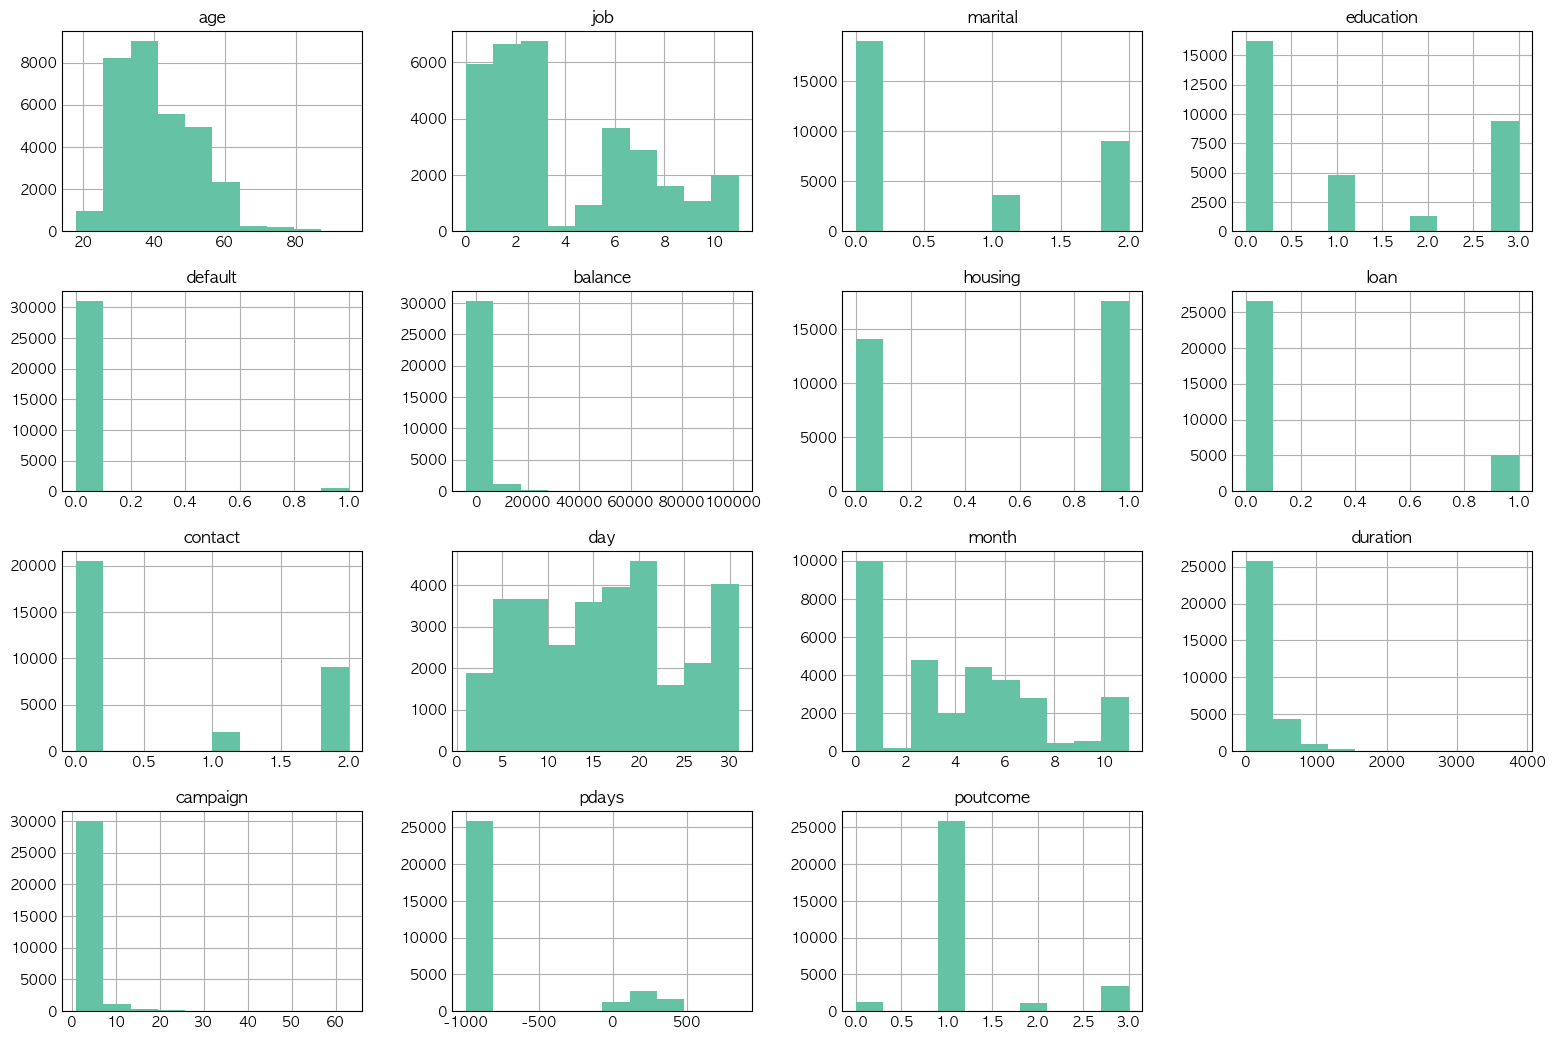

In [97]:
train_X.hist(figsize=(15,10))

### 4.2 상관도(correlation) 확인
* 종속변수(정기예금 가입여부)와 다른 독립변수들과의 correlation을 확인한다.

In [98]:
train_merge_df = pd.concat([train_X, train_y_df], axis=1)

# 상관 계수를 label과 높은 순서로 정렬하여 출력
correlation_with_label = train_merge_df.corr()['label'].sort_values(ascending=False)

# 보기 좋게 출력
print("Correlation with 'label' (sorted by descending order):")
print("-" * 50)
for feature, corr_value in correlation_with_label.items():
    print(f"{feature:<20} {corr_value:.2f}")
print("-" * 50)

Correlation with 'label' (sorted by descending order):
--------------------------------------------------
label                1.00
duration             0.39
pdays                0.15
month                0.10
poutcome             0.08
marital              0.06
education            0.06
balance              0.05
age                  0.03
job                  0.01
default              -0.02
day                  -0.03
loan                 -0.07
campaign             -0.07
housing              -0.14
contact              -0.15
--------------------------------------------------


* 상관관계 해석 방법
    * 상관 계수는 -1에서 1 사이의 값을 가지며, 두 변수 간의 선형 관계를 나타냄
    * 1: 완벽한 양의 상관 관계 (한 변수가 증가하면 다른 변수도 증가).
    * 0: 상관 관계 없음 (독립적).
    * -1: 완벽한 음의 상관 관계 (한 변수가 증가하면 다른 변수는 감소).
* 위의 label과의 상관관계 해석
    * label: 1.00 - 자기 자신과의 상관 계수이므로 항상 1입니다. 따라서 해석에서 제외함
    * duration(통화시간): 0.39
        * 가장 높은 상관 관계를 가짐. duration이 증가할수록 label(정기예금가입)이 증가할 가능성이 높음을 시사.
    * contact(연략방법): 0.15, housing(주택대출여부): 0.14 약한 양의 상관 관계가 있음. 이 변수들이 label에 어느 정도 긍정적 영향을 미칠 가능성이 있음.
    * month(연락한 달): -0.05, campaign(연락횟수): -0.07, poutcome: -0.12(이전참여여부). 약한 음의 상관 관계를 가짐. 이 변수들이 증가하면 label은 감소할 가능성이 있음.
    * education, job 등은 거의 상관 관계가 없으므로 모델링에서 중요도가 낮을 수 있음.

* 상관도를 heatmap으로 확인한다.

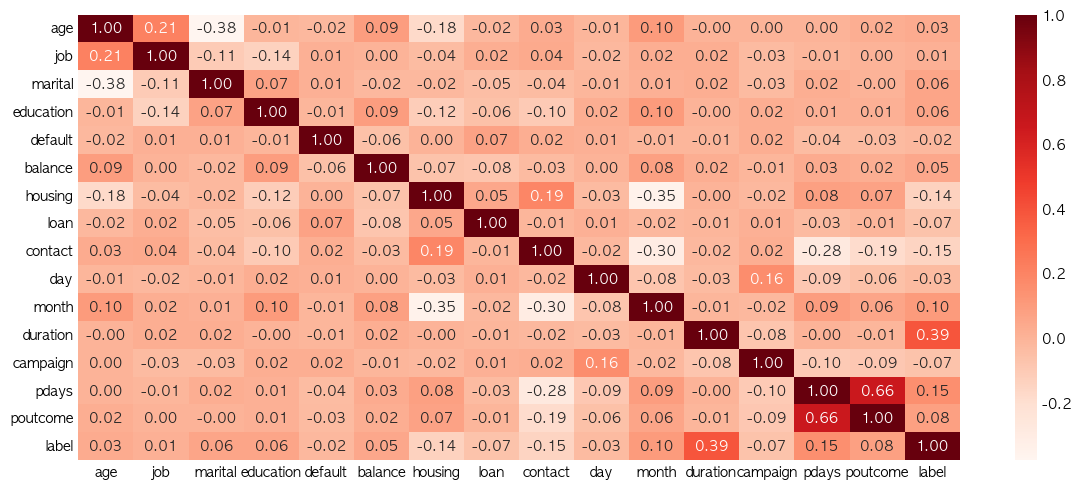

In [99]:
corr_mat = train_merge_df.corr()
plt.figure(figsize=(12, 5))
ax = sns.heatmap(round(corr_mat, 2),
                 cmap='Reds', annot=True, annot_kws={"size": 10}, fmt='.2f')
plt.tight_layout()
plt.show()

* heatmap 해석방법
    * 색이 진할수록 변수들간의 상과도가 높은 것으로 label변수와는 duration, housing, contract 등의 변수들이 조금 진한 색상으로 상관도가 높은 것을 나타내고 있다.

### 4.3 통화시간(duration) 변수와 가입여부(label)변수와의 관계 확인
* boxplot이용

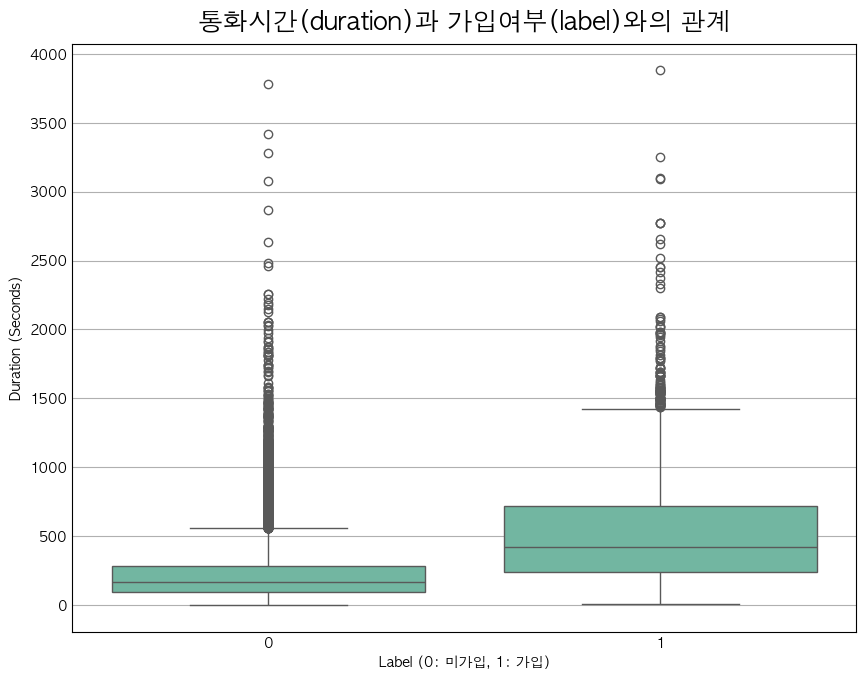

In [100]:
# 박스 플롯 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='duration', data=train_merge_df)
plt.title("통화시간(duration)과 가입여부(label)와의 관계", fontdict=font, pad=10)
plt.xlabel("Label (0: 미가입, 1: 가입)")
plt.ylabel("Duration (Seconds)")
plt.show()

* 챠트해석
    * duration(통화시간)이 길수록 가입할 가능성이 높아짐

### 4.4 대출상태(loan_status)와 가입여부(label)변수와의 관계 확인
* countplot으로 확인

In [101]:
'''
train_merge_df_1 = pd.concat([train_x_df, train_y_df], axis=1)

# 카운트플롯 시각화
plt.figure(figsize=(8, 6))

sns.countplot(x='loan_status', hue='label', data=train_merge_df_1, palette="Set2")
plt.title("대출상태(loan_status)와 가입여부(label)와의 관계", fontdict=font, pad=10)
plt.xlabel("대출상태")
plt.ylabel("Count")
plt.legend(title="Label (0: 미가입, 1: 가입)", loc="upper right")
plt.show()
'''

'\ntrain_merge_df_1 = pd.concat([train_x_df, train_y_df], axis=1)\n\n# 카운트플롯 시각화\nplt.figure(figsize=(8, 6))\n\nsns.countplot(x=\'loan_status\', hue=\'label\', data=train_merge_df_1, palette="Set2")\nplt.title("대출상태(loan_status)와 가입여부(label)와의 관계", fontdict=font, pad=10)\nplt.xlabel("대출상태")\nplt.ylabel("Count")\nplt.legend(title="Label (0: 미가입, 1: 가입)", loc="upper right")\nplt.show()\n'

* 챠트 해석
    * 대출이 없는 경우 정기예금 가입이 증가할 가능성이 높아짐

### 4.5 이전 참여여부(poutcome)과 가입여부(label)변수와의 관계 확인
* countplot으로 확인

In [102]:
train_merge_df_1 = pd.concat([train_x_df, train_y_df], axis=1)

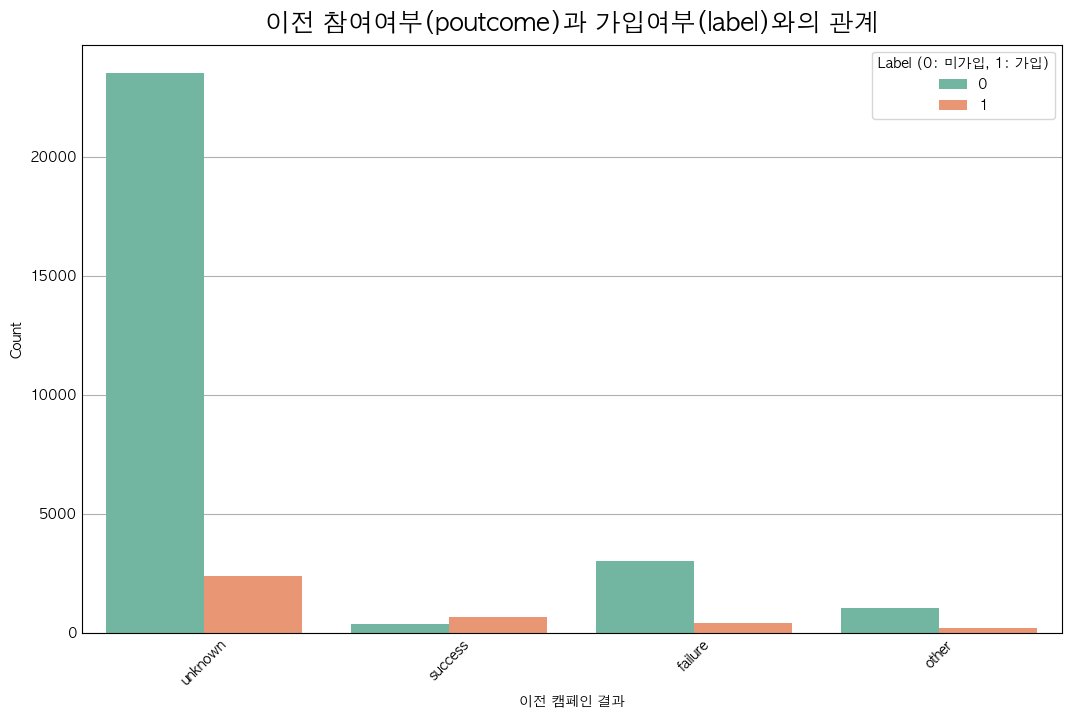

In [103]:
# poutcome과 label 간의 관계를 표현하는 카운트플롯
plt.figure(figsize=(10, 6))
sns.countplot(x='poutcome', hue='label', data=train_merge_df_1, palette="Set2")
plt.title("이전 참여여부(poutcome)과 가입여부(label)와의 관계", fontdict=font, pad=10)
plt.xlabel("이전 캠페인 결과")
plt.ylabel("Count")
plt.legend(title="Label (0: 미가입, 1: 가입)", loc="upper right")
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()

* 챠트해석
    * unKnown 범주 값이 크긴하나, success, failure 범주만 비교해보아도, 이전 가입 캠페인에서 실패한 고객의 경우 정기예금 가입을 안할 가능성이 높아짐

In [104]:
# poutcome과 label 간의 관계를 표현하는 카운트플롯
'''
plt.figure(figsize=(10, 6))
sns.countplot(x='balance_group', hue='label', data=train_merge_df_1, palette="Set2")
plt.title("이전 참여여부(poutcome)과 가입여부(label)와의 관계", fontdict=font, pad=10)
plt.xlabel("이전 캠페인 결과")
plt.ylabel("Count")
plt.legend(title="Label (0: 미가입, 1: 가입)", loc="upper right")
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()
'''

'\nplt.figure(figsize=(10, 6))\nsns.countplot(x=\'balance_group\', hue=\'label\', data=train_merge_df_1, palette="Set2")\nplt.title("이전 참여여부(poutcome)과 가입여부(label)와의 관계", fontdict=font, pad=10)\nplt.xlabel("이전 캠페인 결과")\nplt.ylabel("Count")\nplt.legend(title="Label (0: 미가입, 1: 가입)", loc="upper right")\nplt.xticks(rotation=45)  # x축 레이블 회전\nplt.show()\n'

## 5. 변수 선택하기

### 5.1  VarianceThreshold
- sklearn.feature_selection.VarianceThreshold를 미사용 변수 제외하고 태움 (threshold 변수는 별도 파라미터 지정)

* VarianceThreshold를 사용해 데이터에서 분산이 일정 기준(threshold)보다 작은 피처를 제거하고, 분산이 큰 피처만 남기기 위한 과정
* 특정 값의 변동성이 거의 없는 피처(=분산이 낮은 피처)를 제거하는 데 유용
* VarianceThreshold는 각 피처의 분산을 계산하고, 설정한 threshold보다 큰 피처만 선택하도록 준비
* 분산이 거의 없는(즉, 데이터에 거의 변동이 없는) 피처들을 제거함으로써, 더 의미 있는 피처만 남겨 분석이나 모델링에 사용할 수 있게 된다.

In [105]:
# VarianceThreshold를 통해
# variance가 threshold 보다 큰 것만 남기기
from sklearn.feature_selection import VarianceThreshold

print(train_X.shape)

var_selector = VarianceThreshold(threshold=VAR_THRESHOLD) # threshold 설정
var_selector.fit(train_X)

# constant 컬럼
# 분산이 낮아서 제거될 피처(=constant columns)를 선택해 constant 변수에 저장하고, 그 목록과 개수를 출력
constant = train_X.columns[~var_selector.get_support()]
print(f'Low variance columns ({len(constant)}) : {list(constant)}') 

# non-constant 컬럼
# 분산이 threshold보다 큰 피처만 선택해 non_constant 변수에 저장하고, 그 목록과 개수를 출력
non_constant = train_X.columns[var_selector.get_support()]
print(f'Non-constant columns ({len(non_constant)}) : {list(non_constant)}')

(31647, 15)
Low variance columns (0) : []
Non-constant columns (15) : ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'poutcome']


In [106]:
# VarianceThreshold 결과 선택된 non-constant 컬럼들에 대해
# categorical/numerical 분류 (다음 단계에서 numerical 컬럼들에 대해 FDR을 수행하기 위함)

cat_cols_var_selected = []
num_cols_var_selected = []
for col in non_constant:
  if col in numerical_columns:
    num_cols_var_selected.append(col)
  else:
    cat_cols_var_selected.append(col)

print(f'Categorical ({len(cat_cols_var_selected)}) : {list(cat_cols_var_selected)}')
print(f'Numerical ({len(num_cols_var_selected)}) : {list(num_cols_var_selected)}')

Categorical (10) : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']
Numerical (5) : ['age', 'balance', 'duration', 'campaign', 'pdays']


### 5.2. FDR(False Discovery Rate)
- numeric 변수들에 대해 sklearn.feature_selection.SelectFdr 사용
- score_func: classif 사용
- alpha: 별도 파라미터로 지정

* 사이킷런의 SelectFdr은 통계적인 방법을 사용하여 데이터에서 중요한 특성(feature)을 선택하는 기능을 제공
* 여기서 "FDR"은 False Discovery Rate를 뜻하며, 이는 거짓 긍정(False Positives) 결과의 비율을 의미
* SelectFdr는 주어진 유의 수준(significance level)보다 p-값(p-value)이 작은 특성들만 선택
* 이 유의 수준은 사용자가 설정할 수 있으며, 기본적으로 alpha=0.05로 설정되어 있다.
* 각 특성에 대해 통계 검정을 수행하여 p-값을 계산합니다.
* 각 p-값과 설정된 FDR 임계값을 비교하여, 이보다 작은 p-값을 가지는 특성들을 선택
* 이 방법은 특히 특성이 많고, 그 중 일부만이 실제로 중요한 경우에 유용 
* FDR 방식을 사용하면 선택된 특성 중에서 거짓 긍정의 비율이 일정 수준 이하로 유지되도록 조정할 수 있어, 많은 특성을 다루는 상황에서 유용한 선택 방법

* 분류문제에서 사용하기 위한 F 검정 수행, P값보다 작은 특징들만 선택(여기서는 일단 P값의 유의수준을 0.05로 설정)
* 회귀일때는 f_regression

In [ ]:
from sklearn.feature_selection import SelectFdr, f_classif, f_regression

print(f'Out of {len(numerical_columns)} numerical features')

# FDR
fdr_selector = SelectFdr(score_func=f_classif, alpha=FDR_ALPHA)
fdr_selector.fit(train_X[num_cols_var_selected], train_y_df) # non-constant 컬럼들 중 numeric 컬럼만

mask = fdr_selector.get_support()
print('Selected numerical features:', sum(mask))
num_cols_fdr_selected = list(train_X[num_cols_var_selected].columns[mask]) # selected numeric features
print('Selected list:', num_cols_fdr_selected)

Out of 5 numerical features
Selected numerical features: 5
Selected list: ['age', 'balance', 'duration', 'campaign', 'pdays']


* 변수선택에서 선택된 특징들만 남긴다.

In [108]:

cols_filter_selected = list(cat_cols_var_selected + num_cols_fdr_selected)
print(len(cols_filter_selected), cols_filter_selected)

15 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'age', 'balance', 'duration', 'campaign', 'pdays']


In [109]:
# 선택된 컬럼들로만 Train/Test dataframe 필터링
X_train_filter_selected = train_X[cols_filter_selected].copy()
X_test_filter_selected = test_X[cols_filter_selected].copy()

print(X_train_filter_selected.shape)
X_train_filter_selected.head(3)

(31647, 15)


,job,marital,education,default,housing,loan,contact,day,month,poutcome,age,balance,duration,campaign,pdays
0,3,0,1,0,1,0,2,23,0,1,34,358,100,4,-999
1,3,0,0,0,1,0,2,20,0,1,33,-53,172,1,-999
2,2,2,3,0,1,0,0,2,11,1,32,207,56,1,-999


### 5.3 RFECV

* Recursive Feature Elimination with Cross-Validation의 약자
* 머신러닝 모델에서 중요한 특성(feature)만 선택하기 위해 사용되는 기법
* 하나씩 특성을 제거하면서 성능을 평가하여 최적의 특성 조합을 찾아낸다.

* 작동방법
    * 모델 학습: 처음에는 모든 특성을 사용하여 모델을 학습
    * 중요하지 않은 특성 제거: 모델이 평가한 특성 중요도나 계수를 기준으로 가장 덜 중요한 특성을 하나씩 제거
    * 반복: 특성을 하나씩 제거한 후 남은 특성으로 모델을 다시 학습하고 성능을 평가. 과정을 반복하면서 최적의 성능을 낼 수 있는 특성 조합을 찾아낸다.
    * 교차 검증(Cross-Validation): 각 단계마다 교차 검증을 통해 성능을 평가하여 과적합을 방지하고 더 일반화된 성능을 측정

* RFECV의 특징
    * 최적의 특성 개수를 자동으로 선택
    * 교차 검증을 통해 성능이 가장 좋은 특성 조합을 찾을 수 있어, 사용자가 직접 특성 개수를 지정하지 않아도 된다.
    * 과적합 방지에 효과적
    * 교차 검증을 통해 반복적으로 검증하므로, 과적합이 일어날 가능성을 줄인다.

* RFECV는 중요한 특성만 남겨서 모델의 성능을 높이고, 교차 검증을 통해 최적의 특성 개수를 자동으로 선택하는 기능을 제공

In [110]:
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, root_mean_squared_error

# 분류문제일때 f1_score
def custom_scoring(y_true, y_pred):
  f1_binary = round(f1_score(y_true, y_pred, average='binary'), ndigits=0) # class가 string type인 경우 pos_label='1'와 같이 설정 필요
  f1_binary = round(f1_score(y_true, y_pred, average='binary'), ndigits=1)
  #f1_binary = f1_score(y_true, y_pred, average='binary')
  return f1_binary


def rfecv_feature_selection(data, train_target, rfe_estimator, rfe_scoring):
  # Initialize estimator
  if rfe_estimator == "RandomForest":
      # Random Forest Classifier
      estimator_rfe = RandomForestClassifier() # n_estimators: 256으로 고정
  elif rfe_estimator == "LogisticRegression":
      # Logistic Regression
      estimator_rfe = LogisticRegression() # max_iter: 100(default)으로 고정 -- 샘플 데이터 수가 적어 300으로 temporarily 설정
  else:
      # AdaBoostClassifier
      estimator_rfe = AdaBoostClassifier() # 50 고정
  # Fit RFECV
  rfecv = RFECV(estimator=estimator_rfe, step=1, cv=RFE_CV, scoring=rfe_scoring) # cv: 데이터 소요시간에 따라 2~5 수준에서 추후 결정
  rfecv.fit(data, train_target)
  # Select feature based on RFE
  print('Optimal number of features: {}'.format(rfecv.n_features_))
  rfe_top_features = data.columns[rfecv.support_].tolist()
  print(rfe_top_features)

  return rfe_top_features, rfecv

rfe_estimators = ["RandomForest", "LogisticRegression", "AdaBoost"]
rfe_scoring = make_scorer(custom_scoring, greater_is_better=True) # 분류일때


rfecv_result_df = pd.DataFrame()
for rfe_estimator in rfe_estimators:
  print(rfe_estimator)
  rfe_top_features, rfecv = rfecv_feature_selection(X_train_filter_selected, train_y_df, rfe_estimator, rfe_scoring)
  new_row = pd.DataFrame([{'model': rfe_estimator, 'features_selected': rfe_top_features}])
  rfecv_result_df = pd.concat([rfecv_result_df, new_row], ignore_index=True)

rfecv_result_df

RandomForest
Optimal number of features: 6
['day', 'month', 'age', 'balance', 'duration', 'pdays']
LogisticRegression
Optimal number of features: 13
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'age', 'duration', 'campaign']
AdaBoost
Optimal number of features: 14
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'age', 'balance', 'duration', 'campaign', 'pdays']


,model,features_selected
0,RandomForest,"[day, month, age, balance, duration, pdays]"
1,LogisticRegression,"[job, marital, education, default, housing, lo..."
2,AdaBoost,"[job, marital, education, housing, loan, conta..."


* RFECV (Recursive Feature Elimination with Cross-Validation) 과정을 통해 선택된 특성(feature) 개수에 따른 평균 테스트 정확도(mean test accuracy)를 확인한다.

[0.    0.25  0.375 0.4   0.4   0.4   0.4   0.4   0.4   0.4   0.4   0.4
 0.425 0.45  0.45 ]


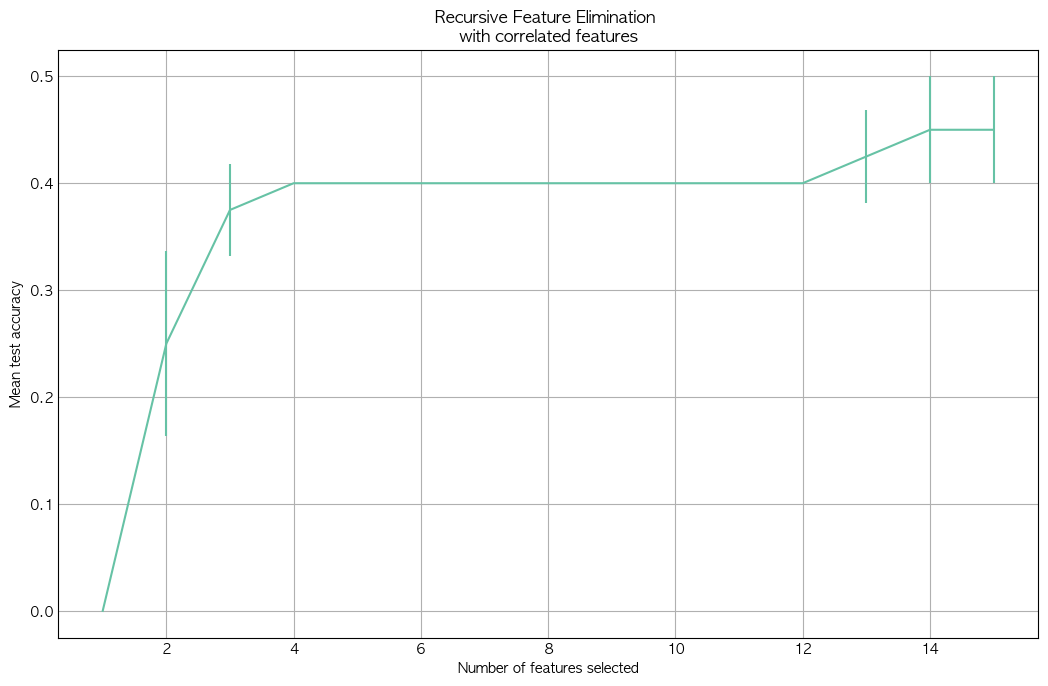

In [111]:
# RFECV 과정 시각화
print(rfecv.cv_results_['mean_test_score'])

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.errorbar(
    range(1, n_scores+1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"]
)

plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show();

* 위 그래프 해석하기
    * X축 (Number of features selected)
        * 선택된 특성의 개수
        * 왼쪽으로 갈수록 적은 특성이 사용된 것이고, 오른쪽으로 갈수록 더 많은 특성이 사용된 것
    * Y축 (Mean test accuracy)
        * 각 특성 개수에 대해 측정된 모델의 평균 테스트 정확도
        * 값이 높을수록 모델 성능이 좋다는 의미
    * 파란색 선
        * 이 선은 각 특성 개수에 따른 평균 테스트 정확도의 변화
        * 특성의 개수가 증가함에 따라 성능이 어떻게 변하는지 한눈에 볼 수 있다.
    * 세로선 (오차 범위)
        * 각 지점에 있는 세로선은 표준 편차를 나타내며, 모델 성능의 변동성
        * 이 선이 길수록 해당 특성 개수에서 모델의 성능이 더 크게 변할 수 있다는 의미
    * 그래프 해석
        * 처음에는 특성의 개수가 증가할수록 모델 성능이 좋아지다가, 특정 개수 이후에는 성능이 거의 일정하게 유지되거나 약간의 변동을 보임 - 이를 통해 최적의 특성 개수를 선택가능
        * 최적의 특성 개수는 성능이 높고 오차 범위가 작은 구간을 기준으로 결정할 수 있다.
        * 이 그래프를 통해 모델 성능을 높이기 위해 필요한 특성의 개수를 결정하고, 불필요한 특성을 제거하여 모델을 최적화할 수 있다.
* 위 그래프에서 변수의 개수가 4~5개일때 가장 높은 성능을 보이는 것을 확인할 수 있다.

* RFECV를 "RandomForest", "LogisticRegression", "AdaBoost" 세 모델을 통해 선택된 모든 변수들로 최종 모델 예측에 활용

In [112]:
cols = sum(rfecv_result_df['features_selected'], [])
wrapper_selected_cols = sorted(set(cols), key=cols.index)
print(len(wrapper_selected_cols), wrapper_selected_cols)

# dataframe 필터링
X_train_selected = X_train_filter_selected[wrapper_selected_cols].copy()
X_test_selected = X_test_filter_selected[wrapper_selected_cols].copy()
print('X train:', X_train_selected.shape, '/ X test:', X_test_selected.shape)

X_train_selected.head(3)

15 ['day', 'month', 'age', 'balance', 'duration', 'pdays', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'campaign']
X train: (31647, 15) / X test: (13564, 15)


,day,month,age,balance,duration,pdays,job,marital,education,default,housing,loan,contact,poutcome,campaign
0,23,0,34,358,100,-999,3,0,1,0,1,0,2,1,4
1,20,0,33,-53,172,-999,3,0,0,0,1,0,2,1,1
2,2,11,32,207,56,-999,2,2,3,0,1,0,0,1,1


## 6. 베스트 예측모델 선정

### 6.1 H2O

* 방대한 데이터에 대해 머신 러닝을 빠르게 수행하고, 분석 및 예측을 도와주는 라이브러리
* AUTOML(자동화된 머신 러닝)로 베스트 모델을 빠르게 선정하기 위해 활용
* AutoML을 썼다고 말하지 말고, 베스트 모델로 선정된 모델에 대해서 발표하는 것이 나을 듯함
* 몇가지 모델 비교 예시는 아래에 수행내역중 AutoML에서 리턴된 결과중 2,3개의 모델에 대해 기술해서 비교하고, 베스트 모델에 대해서 설명하는 것이 좋을듯함

#### 6.1.1 H2O 불러오기

In [113]:
import h2o
from h2o.automl import H2OAutoML
h2o.init() # initialize H2O cluster

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.1" 2021-10-19; OpenJDK Runtime Environment (build 17.0.1+12-39); OpenJDK 64-Bit Server VM (build 17.0.1+12-39, mixed mode, sharing)
  Starting server from /Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/jw/wdnx0tjx7kzdqt8y2gcwtz940000gn/T/tmplrjupyq0
  JVM stdout: /var/folders/jw/wdnx0tjx7kzdqt8y2gcwtz940000gn/T/tmplrjupyq0/h2o_choiwooyeon_started_from_python.out
  JVM stderr: /var/folders/jw/wdnx0tjx7kzdqt8y2gcwtz940000gn/T/tmplrjupyq0/h2o_choiwooyeon_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_choiwooyeon_hv2e5j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


#### 6.1.2 H2O 데이터 준비

In [114]:
# X, y 의 컬럼 이름을 predictors, response로 선언
predictors = list(X_train_selected.columns) # X 컬럼 리스트
response = train_y_df.name # y 컬럼 리스트

predictors, response

(['day',
  'month',
  'age',
  'balance',
  'duration',
  'pdays',
  'job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'poutcome',
  'campaign'],
 'label')

In [115]:
# H2O Frame 변환
'''
- H2O를 사용하기 위해 H2O Frame으로 변환 필요
- 분류 모델인 경우, response(target) 변수는 'factor'여야 함
'''
# Train
train_df = pd.concat([X_train_selected, train_y_df], axis=1) # X+y 결합 dataframe
train_hf = h2o.H2OFrame(train_df.copy()) # H2O Frame으로 변환
train_hf[response] = train_hf[response].asfactor() # target 컬럼 categorical로 변환
# Test
test_df = pd.concat([X_test_selected], axis=1)
test_hf = h2o.H2OFrame(test_df.copy())

train_hf.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:31647
Cols:16

,day,month,age,balance,duration,pdays,job,marital,education,default,housing,loan,contact,poutcome,campaign,label
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,0.0,18.0,-4057.0,0.0,-999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,
mean,15.818276613897037,3.9570891395708956,40.91683255916842,1370.0500837362076,258.08882358517474,-777.1840932789821,3.938319587954633,0.682465952538938,1.1179574683224223,0.01763200303346289,0.5566720384238633,0.15894081587512243,0.6384175435270336,1.2095301292381466,2.7526147818118685,
maxs,31.0,11.0,95.0,102127.0,3881.0,854.0,11.0,2.0,3.0,1.0,1.0,1.0,2.0,3.0,63.0,
sigma,8.315467414349524,3.3432983951283655,10.621773208087523,3122.054995670937,255.73756815149898,474.16472498573484,3.0764429196059684,0.8860377500015751,1.3123252587939533,0.13161178838651535,0.49678574704240036,0.36562666356739404,0.8971189843341328,0.6792210732083214,3.0809519783342503,
zeros,0,9647,0,2440,3,0,5288,19042,16250,31089,14030,26617,20525,1259,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,23.0,0.0,34.0,358.0,100.0,-999.0,3.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,4.0,0
1,20.0,0.0,33.0,-53.0,172.0,-999.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0
2,2.0,11.0,32.0,207.0,56.0,-999.0,2.0,2.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0


#### 6.1.3 H2OAutoML 수행

* max_models: 학습시킬 최대 모델 수를 설정
    * 예를 들어, MAX_MODELS = 10으로 설정하면 최대 10개의 모델을 학습
* max_runtime_secs : AutoML 전체에 할당할 최대 실행 시간을 초 단위로 지정
    * 이 시간 안에 가능한 많은 모델을 학습하고 평가
* max_runtime_secs_per_model : 각 모델의 학습에 할당할 최대 시간을 초 단위로 지정
    * 특정 모델이 너무 오래 걸리는 것을 방지하기 위해 제한을 설정
* nfolds : -1로 설정하면 AutoML이 자동으로 k-폴드 교차 검증 또는 블렌딩 모드를 선택합니다.
    * 교차 검증을 통해 모델의 일반화 성능을 더 잘 평가할 수 있습니다.

* 이 코드는 H2O의 AutoML을 통해 주어진 학습 데이터에서 다양한 머신 러닝 모델을 학습시키고 평가하여, 시간과 모델 수 제한 내에서 최적의 모델을 찾는 과정

In [116]:
class_distribution = train_hf['label'].table().as_data_frame()

# 각 클래스의 비율 계산
total_samples = class_distribution['Count'].sum()
class_distribution['class_sampling_factors'] = total_samples / (len(class_distribution) * class_distribution['Count'])

print(class_distribution)
class_factors = class_distribution['class_sampling_factors'].tolist()
print(class_factors)

   label  Count  class_sampling_factors
0      0  27945                0.566237
1      1   3702                4.274311
[0.5662372517444981, 4.274311183144246]


/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [117]:
# H2O AutoML 수행
aml = H2OAutoML(max_models = MAX_MODELS,
                max_runtime_secs = MAX_RUNTIME_SECS, # stopping parameters
                max_runtime_secs_per_model = MAX_RUNTIME_SECS_PER_MODEL,
                nfolds = 10, # -1: AutoML chooses if k-fold cross-validation or blending mode should be used.
                balance_classes=True,
                class_sampling_factors = class_factors,
                keep_cross_validation_predictions=True,
                sort_metric="AUCPR",
                stopping_metric = "logloss",
                exclude_algos=["GLM", "DeepLearning"],
                seed = SEED)
aml.train(x=predictors, y=response, training_frame=train_hf)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/10
# GBM base models (used / total),5/5
# XGBoost base models (used / total),2/3
# DRF base models (used / total),1/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,10
Metalearner fold_column,None
Custom metalearner hyperparameters,None


### 6.2 모델 선정 결과
#### 6.2.1 Leaderboard

* 아래 출력결과를 활용하여 2,3개의 모델에 대해 테스트 해 보았으며, 그 중 가장 베스트 모델은 어떤 모델인지 설명
* 성능 값들(rmse, mse, mae 등)을 서로 비교하여 설명

In [118]:
import os
from datetime import datetime
from h2o.automl import get_leaderboard

# AutoML 리더보드 출력
lb = get_leaderboard(aml, extra_columns='ALL') # 모든 출력 가능한 컬럼 출력
lb_pd = lb.as_data_frame() # pandas dataframe 변환
display(lb.head(rows=lb.nrows))

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20241201_114358,0.615286,0.933373,0.198316,0.170104,0.250562,0.0627816,12221,0.020852,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20241201_114358,0.612417,0.931008,0.201021,0.175481,0.251974,0.0634908,11928,0.015539,StackedEnsemble
GBM_5_AutoML_1_20241201_114358,0.605215,0.928873,0.205849,0.176106,0.254972,0.0650107,746,0.012858,GBM
GBM_2_AutoML_1_20241201_114358,0.602071,0.930577,0.204636,0.189337,0.254656,0.0648499,822,0.014625,GBM
GBM_3_AutoML_1_20241201_114358,0.600255,0.930684,0.206501,0.182319,0.255488,0.0652742,716,0.013897,GBM
GBM_1_AutoML_1_20241201_114358,0.598008,0.930671,0.205007,0.17645,0.255114,0.065083,1230,0.012825,GBM
XGBoost_3_AutoML_1_20241201_114358,0.592958,0.924955,0.291851,0.177496,0.302802,0.0916889,3388,0.010707,XGBoost
GBM_4_AutoML_1_20241201_114358,0.592885,0.92851,0.213829,0.168095,0.259649,0.0674175,735,0.011058,GBM
XGBoost_1_AutoML_1_20241201_114358,0.568224,0.919838,0.264712,0.200026,0.28542,0.0814648,4418,0.011353,XGBoost
DRF_1_AutoML_1_20241201_114358,0.566601,0.920365,0.250366,0.170555,0.279732,0.0782499,1342,0.017637,DRF


* 해석
    * GLM은 일반화 선형 모델, GBM은 그래디언트 부스팅 머신, DRF는 분산 랜덤 포레스트, XGBoost는 XGBoost 알고리즘입니다. 
    * StackedEnsemble은 여러 모델을 결합하여 성능을 향상시키는 방식
    * GLM 모델이 RMSE, MSE, MAE 등에서 가장 낮은 값을 보이며 가장 성능이 좋은 모델
    * StackedEnsemble 모델은 여러 모델을 조합하여 성능을 개선하려고 하였지만, 단일 모델보다 큰 개선은 없다.
    * XGBoost 모델들은 RMSE와 MSE가 상대적으로 높아 다른 모델들에 비해 성능이 떨어지는 것으로 보임.


* K-fold 교차검증을 한 내역에 대해서도 설명
* 아래 출력값중에 Cross-Validation Metrics Summary 이부분: 총 5fold의 K-fold 교차검증 수행
* GLM모델에 대한 하이퍼파라메타 값들 간단히 설명, GLM Model: summary 이부분

In [119]:
aml.leader

key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/10
# GBM base models (used / total),5/5
# XGBoost base models (used / total),2/3
# DRF base models (used / total),1/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,10
Metalearner fold_column,None
Custom metalearner hyperparameters,None


#### 6.2.2 모델들 비교 설명

### 6.3 Permutation Importance

* Permutation Importance는 모델이 예측을 할 때 어떤 특성이 중요한지를 확인하는 방법
* Permutation Importance는 모델의 예측에 실질적으로 기여한 특성을 알려주어 모델의 해석 가능성을 높여주어, 중요한 특성을 파악함으로써 데이터에 대한 더 깊은 통찰을 얻을 수 있다.

* 모델이 학습한 후, 특정 특성의 값을 무작위로 섞어 성능에 어떤 영향을 미치는지 측정함으로써 그 특성의 중요도를 평가
* 한 번에 하나의 특성을 무작위로 섞어줍니다. 이렇게 하면 모델은 해당 특성을 유용하게 사용할 수 없게 됩니다.
* 성능 비교: 무작위로 섞은 상태에서 모델의 성능을 다시 측정, 이때 성능이 크게 떨어진다면, 그 특성이 모델 예측에 중요한 역할을 했다는 뜻, 반면, 성능이 거의 변하지 않으면 해당 특성이 모델에 별로 중요하지 않았음을 의미
* 중요도 계산: 각 특성에 대해 위 과정을 반복해, 모델 성능에 미친 영향(변화량)을 기준으로 중요도를 평가

In [120]:
pimp_df = aml.leader.permutation_importance(frame=train_hf, use_pandas=True, seed=SEED)
display(pimp_df)

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,Relative Importance,Scaled Importance,Percentage
Variable,,,
duration,0.238800,1.000000,0.525389
month,0.055373,0.231882,0.121828
contact,0.028139,0.117837,0.061910
day,0.028089,0.117626,0.061799
balance,0.017088,0.071557,0.037595
age,0.016065,0.067274,0.035345
pdays,0.013476,0.056434,0.029650
housing,0.012065,0.050522,0.026544
campaign,0.011666,0.048851,0.025666


In [121]:
from h2o.estimators import H2OStackedEnsembleEstimator
top_5_models = [model_id for model_id in lb['model_id'].as_data_frame().head(5)['model_id'].tolist()]

base_models = [
    model_id for model_id in top_5_models if 'StackedEnsemble' not in model_id
]
print(top_5_models)

#base_models.append('Grid_XGBoost_py_2_sid_8edf_model_python_1732592008482_7106_model_34')
print(base_models)
stacked_ensemble = H2OStackedEnsembleEstimator(
    base_models=base_models,
    metalearner_algorithm="glm",
    metalearner_nfolds = 10
)
stacked_ensemble.train(x=predictors, y=response, training_frame=train_hf)

['StackedEnsemble_AllModels_1_AutoML_1_20241201_114358', 'StackedEnsemble_BestOfFamily_1_AutoML_1_20241201_114358', 'GBM_5_AutoML_1_20241201_114358', 'GBM_2_AutoML_1_20241201_114358', 'GBM_3_AutoML_1_20241201_114358']
['GBM_5_AutoML_1_20241201_114358', 'GBM_2_AutoML_1_20241201_114358', 'GBM_3_AutoML_1_20241201_114358']
stackedensemble Model Build progress: |

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


██████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_model_python_1733021032724_4994


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  3/3
# GBM base models (used / total)      3/3
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    10
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04598917362674393
RMSE: 0.21445086529726087
LogLoss: 0.16295479300708135
AUC: 0.9695435270113303
AUCPR: 0.7959707783790778
Gini: 0.9390870540226606
Null degrees of freedom: 10030
Residual degrees of freedom: 10027
Null deviance: 7241.979611413062
Residual deviance: 3269.1990573080666
AIC: 3277.1990573080666

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23617632526936314
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      8393  464   0.0524   (464.0/8857.0)
1      213   961   0.1814   (213.0/1174.0)
Total  8606  1425  0.0675   (677.0/10031.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.236176     0.739515  255
max f2                       0.0812104    0.819479  326
max f0point5                 0.512753     0.750524  159
max accuracy                 0.394793     0.938491  198
max precision                0.970383     1         0
max recall                   0.032611     1         384
max specificity              0.970383     1         0
max absolute_mcc             0.19156      0.706359  272
max min_per_class_accuracy   0.110027     0.910128  310
max mean_per_class_accuracy  0.0812104    0.918728  326
max tns                      0.970383     8857      0
max fns                      0.970383     1173      0
max fps                      0.0295338    8857      399
max tps                      0.032611     1174      384
max tnr                      0.970383     1         0
max fnr                      0.970383     0.999148  0
max fpr                      0.0295338    1         399
max tpr                      0.032611     1         384

Gains/Lift Table: Avg response rate: 11.70 %, avg score: 12.29 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100688                   0.923274           7.95211    7.95211            0.930693         0.941423   0.930693                    0.941423            0.0800681       0.0800681                  695.211   695.211            0.0792778
2        0.0200379                   0.878922           8.03164    7.99168            0.94             0.90282    0.935323                    0.922218            0.0800681       0.160136                   703.164   699.168            0.158669
3        0.030007                    0.835332           7.43353    7.80625            0.87             0.85522    0.913621                    0.899959            0.0741056       0.234242                   643.353   680.625            0.231306
4        0.0400758                   0.784893           6.76776    7.54533            0.792079         0.811988   0.883085                    0.877857            0.0681431       0.302385                   576.776   654.533            0.297078
5 

* plot으로 확인

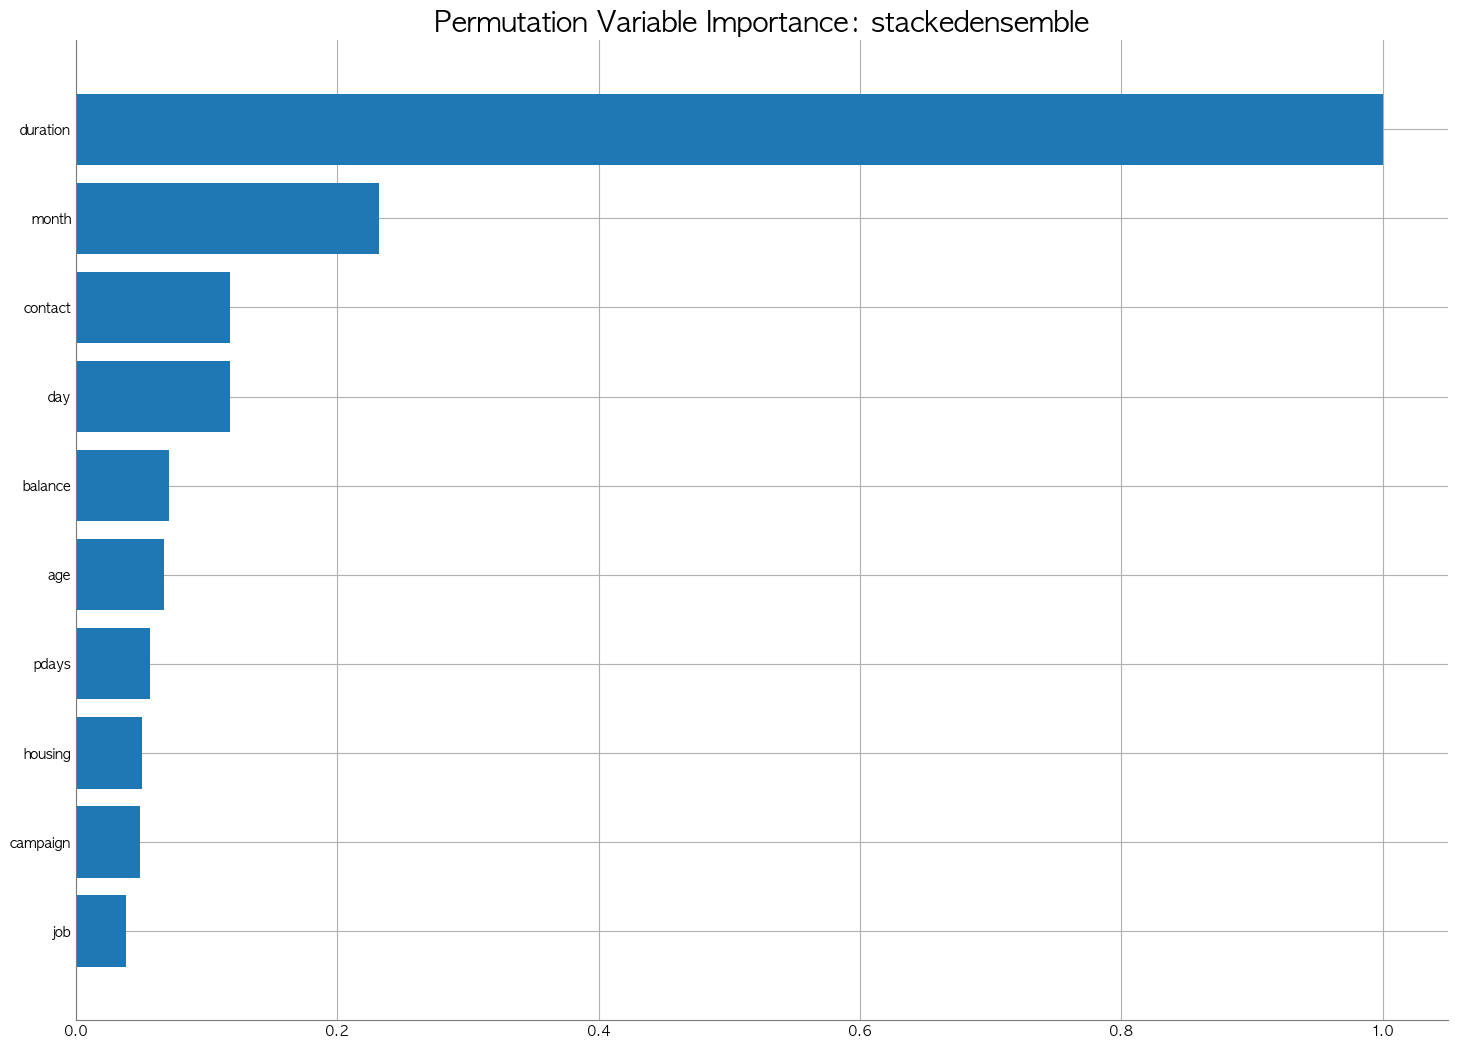

Variable,Relative Importance,Scaled Importance,Percentage
duration,0.2387999,1.0,0.5253886
month,0.0553734,0.2318820,0.1218282
contact,0.0281394,0.1178368,0.0619101
day,0.0280890,0.1176257,0.0617992
balance,0.0170878,0.0715571,0.0375953
age,0.0160651,0.0672743,0.0353452
pdays,0.0134764,0.0564339,0.0296497
housing,0.0120647,0.0505224,0.0265439
campaign,0.0116657,0.0488513,0.0256659
job,0.0091277,0.0382232,0.0200820


In [122]:
aml.leader.permutation_importance_plot(train_hf, seed=SEED)

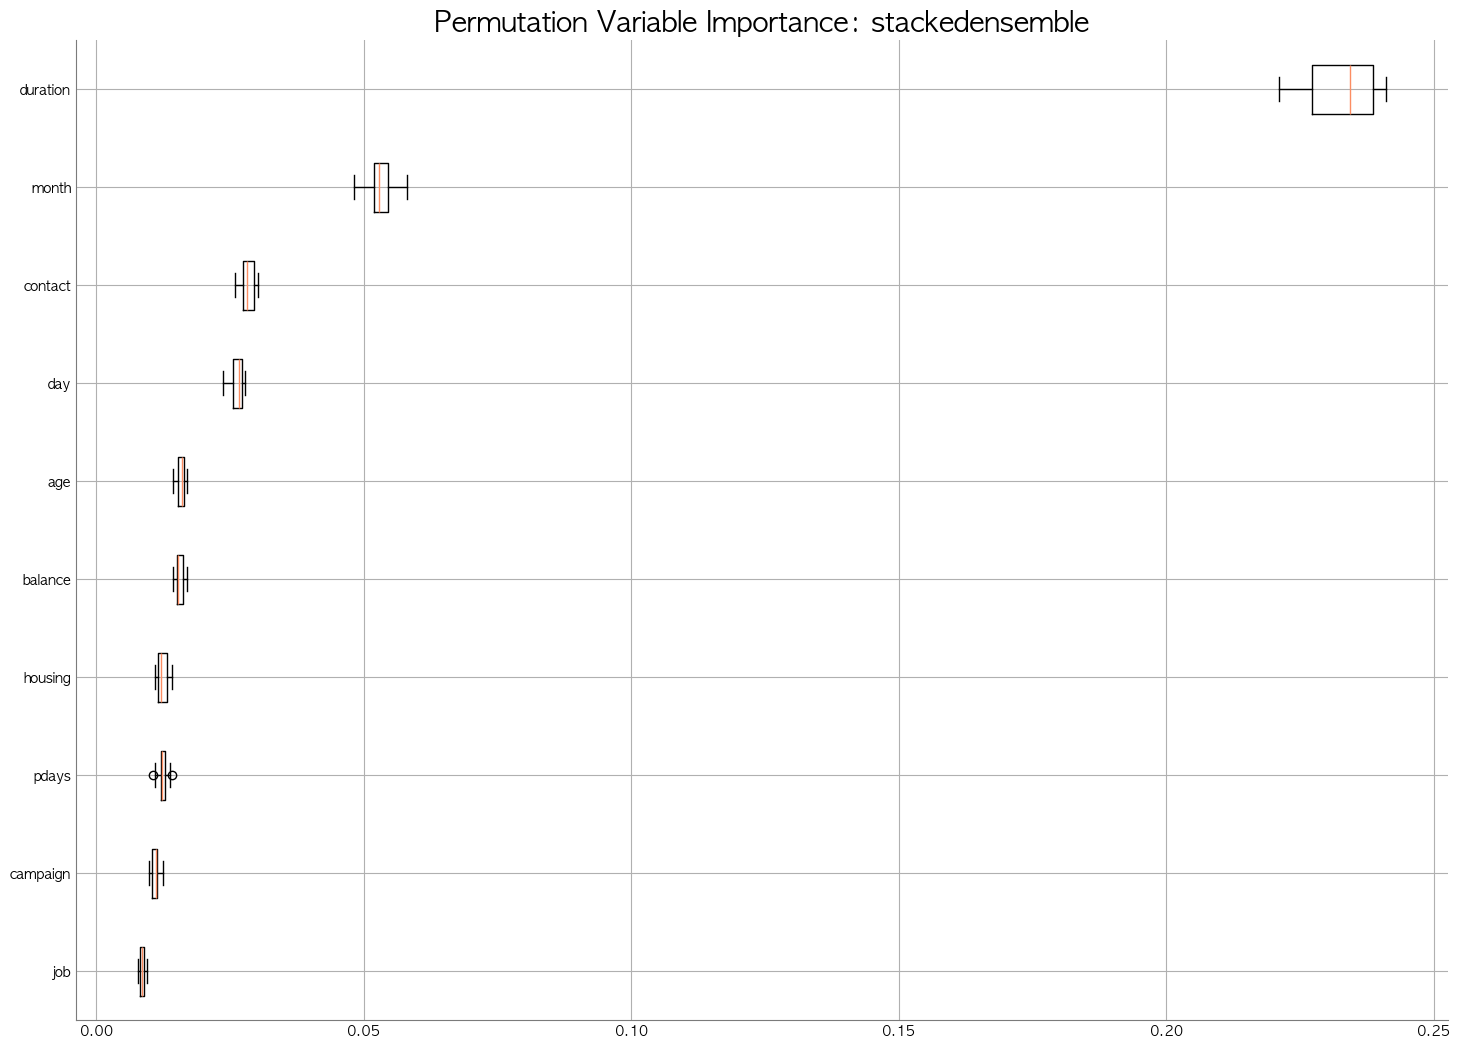

Variable,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10,Run 11,Run 12,Run 13,Run 14,Run 15
duration,0.2334517,0.2350589,0.2396383,0.2338417,0.2275259,0.2230725,0.2263778,0.2343213,0.2404408,0.2375051,0.2268756,0.2211321,0.2409819,0.2397488,0.2363479
month,0.0528357,0.0498054,0.0502268,0.0481039,0.0524221,0.0578337,0.0551313,0.0538107,0.0514111,0.0539350,0.0569178,0.0528314,0.0538172,0.0579613,0.0523073
contact,0.0283362,0.0292425,0.0259766,0.0267308,0.0285974,0.0298899,0.0279368,0.0297798,0.0281928,0.0301292,0.0264147,0.0277027,0.0280268,0.0272002,0.0298155
day,0.0248422,0.0275963,0.0262055,0.0266218,0.0259235,0.0236087,0.0272919,0.0269013,0.0265592,0.0250233,0.0277761,0.0271644,0.0278154,0.0264887,0.0253003
age,0.0168378,0.0159443,0.0159352,0.0157986,0.0143230,0.0143542,0.0156406,0.0164228,0.0153880,0.0150942,0.0161869,0.0166839,0.0169929,0.0162840,0.0152098
balance,0.0158487,0.0151897,0.0152410,0.0152582,0.0149727,0.0142333,0.0152546,0.0162159,0.0148128,0.0160616,0.0168291,0.0163459,0.0157360,0.0150039,0.0161105
pdays,0.0121735,0.0138128,0.0120372,0.0110136,0.0140856,0.0120602,0.0106204,0.0125664,0.0124223,0.0128676,0.0128576,0.0118532,0.0120680,0.0126691,0.0120357
housing,0.0119975,0.0127363,0.0138746,0.0121896,0.0115186,0.0108983,0.0119682,0.0136796,0.0112268,0.0123087,0.0137794,0.0121483,0.0141223,0.0114675,0.0114170
campaign,0.0110775,0.0123582,0.0097479,0.0100642,0.0103734,0.0104071,0.0109384,0.0118621,0.0097498,0.0111256,0.0114002,0.0112555,0.0105613,0.0112136,0.0114152
job,0.0084897,0.0086341,0.0085771,0.0079180,0.0078283,0.0086154,0.0081710,0.0093624,0.0079516,0.0081719,0.0092768,0.0093395,0.0081558,0.0091194,0.0087349


In [123]:
aml.leader.permutation_importance_plot(train_hf, n_repeats=15) # n_repeats 설정시 box plot

### 6.4 테스트 데이터 예측 성능 평가

In [124]:
# 모델 성능 평가
performance = aml.leader.model_performance(test_data=test_hf)
print(performance)


None


### 6.5 테스트데이터 예측결과

In [125]:
test_hf

day,month,age,balance,duration,pdays,job,marital,education,default,housing,loan,contact,poutcome,campaign
20,7,54,6410,101,-999,2,1,3,0,0,0,0,1,2
28,10,56,282,156,-999,5,1,1,0,0,0,0,1,2
21,5,34,355,314,-999,2,0,0,0,0,0,0,1,3
12,5,55,568,940,-999,2,0,3,0,0,0,0,1,10
21,5,38,6728,252,-999,0,0,0,0,0,0,0,1,4
11,2,55,366,173,-999,8,1,0,0,0,0,1,1,1
31,3,43,2105,36,-999,3,0,1,0,1,0,0,1,2
29,10,26,289,220,-999,1,0,0,0,0,0,0,1,1
29,3,54,244,337,-999,3,0,1,0,1,0,0,1,2
6,8,33,1126,11,490,0,0,3,0,1,0,2,0,1


In [126]:
# 테스트 데이터 예측
predictions = aml.leader.predict(test_hf)
preds_pd = predictions['predict'].as_data_frame() # 예측 값 df
print_all(preds_pd.head())

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict
0,0
1,0
2,0
3,1
4,0


In [127]:
result_df = pd.concat([test_data['ID'], preds_pd], axis=1)

In [128]:
result_df.head()

,ID,predict
0,test00001,0
1,test00002,0
2,test00003,0
3,test00004,1
4,test00005,0


In [129]:
result_df.columns = ['ID', 'label']
result_df['label'] = result_df['label'].astype('int')
result_df.to_csv(f"{datetime.now().timestamp()}_submission_example.csv", index=False)

## 7. 리소스정리

In [130]:
# H2O 서버 종료
# h2o.shutdown()

In [131]:
top_5_models = [model_id for model_id in lb['model_id'].as_data_frame().head(5)['model_id'].tolist()]
print(len(top_5_models))

5


/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [132]:
# 각 모델 객체 가져오기
models = [h2o.get_model(model_id) for model_id in top_5_models]
print(len(models))

# 각 모델의 예측값 추출
predictions = []
for i, model in enumerate(models):
    pred = model.predict(test_hf)['predict']
    print(f"Predictions from model {i}:")
    print(pred.head())
    predictions.append(pred.as_data_frame().values.flatten())
# 가중치 설정 (가중 평균 블렌딩, 여기서는 동일한 가중치 적용)
weights = [0.4, 0.3, 0.2, 0.05, 0.05]  # 가중치를 사용자 정의

# 예측 값 블렌딩
blended_predictions = sum(w * p for w, p in zip(weights, predictions))

threshold = 0.5

# 최종 이진 예측값 생성 (0과 1로 변환)
final_predictions = (blended_predictions >= threshold).astype(int)

# 결과 확인
print(final_predictions)

final_predictions_df = pd.DataFrame({'target': final_predictions})
final_predictions_df.to_csv('final_binary_predictions.csv', index=False)

result_df.columns = ['ID', 'label']
result_df['label'] = final_predictions_df.astype('int')
result_df.to_csv(f"{datetime.now().timestamp()}_submission_example.csv", index=False)

5
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Predictions from model 0:
  predict
        0
        0
        0
        1
        0
        0
        0
        0
        0
        0
[10 rows x 1 column]

stackedensemble prediction progress: |

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
Predictions from model 1:
  predict
        0
        0
        0
        1
        0
        0
        0
        0
        0
        0
[10 rows x 1 column]

gbm prediction progress: |

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
Predictions from model 2:
  predict
        0
        0
        0
        1
        0
        1
        0
        0
        0
        0
[10 rows x 1 column]

gbm prediction progress: |

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
Predictions from model 3:
  predict
        0
        0
        0
        1
        0
        1
        0
        0
        0
        0
[10 rows x 1 column]

gbm prediction progress: |

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
Predictions from model 4:
  predict
        0
        0
        0
        1
        0
        1
        0
        0
        0
        0
[10 rows x 1 column]

[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0
 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 

/Users/choiwooyeon/opt/anaconda3/envs/aibp/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
